| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [1]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

In [195]:
import sys, os, importlib

WORK_PATH = "/root/3d-1d"
MODULES_PATH = os.path.join(WORK_PATH, 'modules')

sys.path.append(MODULES_PATH)

In [196]:
from graphnics import FenicsGraph

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

TEST_GRAPH = FenicsGraph()

for node, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node, pos=pos)

for u, v, radius in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

In [197]:
import MeasureCreator
importlib.reload(MeasureCreator)

FACE_XZERO = MeasureCreator.XAxisPlane(0.0)
TEST_MESH = MeasureCreator.MeasureCreator(TEST_GRAPH, [0], FACE_XZERO)

In [198]:
import FEMSink
importlib.reload(FEMSink)

TEST = FEMSink.FEMSink(
    mc = TEST_MESH,
    gamma = 100,
    gamma_R = 1.0e-5,
    gamma_v = 1.0e-5,
    gamma_a = 1.0e-5,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Omega_sink = FACE_XZERO
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2571.57it/s]


Applied BC! Non-empty list


In [199]:
import FEMSinkVelo
importlib.reload(FEMSinkVelo)

VTEST = FEMSinkVelo.FEMSinkVelo(
    mc = TEST_MESH,
    gamma = 100,
    gamma_R = 1.0e-5,
    gamma_v = 1.0e-5,
    gamma_a = 1.0e-5,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Omega_sink = FACE_XZERO
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2549.19it/s]


Applied BC! Non-empty list


Node Pressure Data:
Node 0: Pressure 13332.2
Node 113: Pressure 13131.9
Node 57: Pressure 12913.1
Node 114: Pressure 12685.2
Node 29: Pressure 12433.5
Node 116: Pressure 12181.6
Node 58: Pressure 11929.4
Node 115: Pressure 11650.6
Node 15: Pressure 11264.7
Node 119: Pressure 10878.6
Node 60: Pressure 10492.3
Node 120: Pressure 10108.1
Node 30: Pressure 9727.9
Node 118: Pressure 9345.1
Node 59: Pressure 9007.2
Node 117: Pressure 8697.5
Node 8: Pressure 8387.9
Node 125: Pressure 8078.8
Node 63: Pressure 7817.0
Node 126: Pressure 7626.5
Node 32: Pressure 7436.0
Node 128: Pressure 7245.3
Node 64: Pressure 7053.3
Node 127: Pressure 6855.5
Node 16: Pressure 6657.8
Node 123: Pressure 6473.1
Node 62: Pressure 6292.3
Node 124: Pressure 6111.7
Node 31: Pressure 5930.9
Node 122: Pressure 5777.5
Node 61: Pressure 5642.1
Node 121: Pressure 5506.5
Node 1: Pressure 5371.1
Node 145: Pressure 5186.5
Node 73: Pressure 5010.4
Node 146: Pressure 4860.4
Node 37: Pressure 4722.0
Node 148: Pressure 4583.7
No

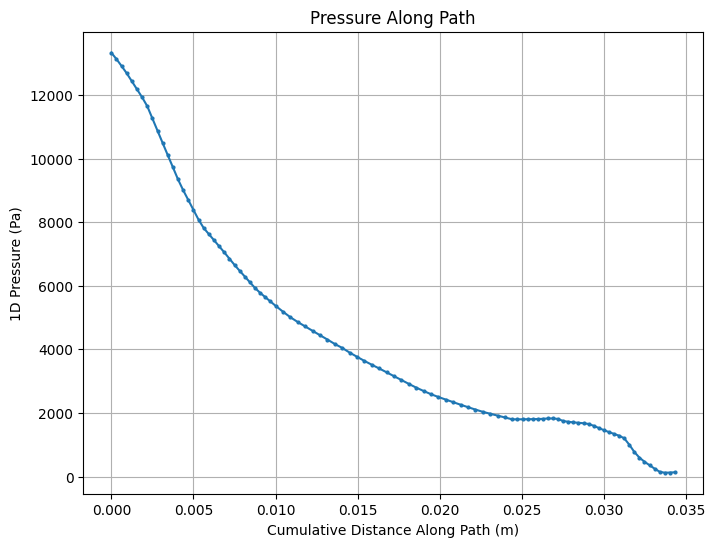

In [200]:
import Visualizer
importlib.reload(Visualizer)
Visualizer.plot_path_pressure(VTEST.uh1d, TEST_GRAPH, [0, 1, 3, 5])

In [203]:
import FEMSinkCubeFlux
import numpy as np
importlib.reload(FEMSinkCubeFlux)

CUBE_TEST = FEMSinkCubeFlux.FEMSinkCubeFlux(
    mc = TEST_MESH,
    gamma = 1.0,
    gamma_R = 1.0,
    gamma_v = 1.0,
    gamma_a = 1450,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.0e-6, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Omega_sink = FACE_XZERO,
    Omega_bounds_dim = [[0,0,0],[0.06,0.06,0.06]],
    upper_cube_bounds = [np.array(TEST_GRAPH.nodes[0]['pos']) - np.array([0.01, 0.01, 0.01]), np.array(TEST_GRAPH.nodes[0]['pos']) + np.array([0.01, 0.01, 0.01])],
    lower_cube_bounds = [np.array(TEST_GRAPH.nodes[4]['pos']) - np.array([0.01, 0.01, 0.01]), np.array(TEST_GRAPH.nodes[4]['pos']) + np.array([0.01, 0.01, 0.01])]
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2476.12it/s]


Applied BC! Non-empty list


Lower Cube Bounds: [array([ 0.005, -0.005,  0.005]), array([0.025, 0.015, 0.025])]
Upper Cube Bounds: [array([-0.01 ,  0.01 ,  0.005]), array([0.01 , 0.03 , 0.025])]


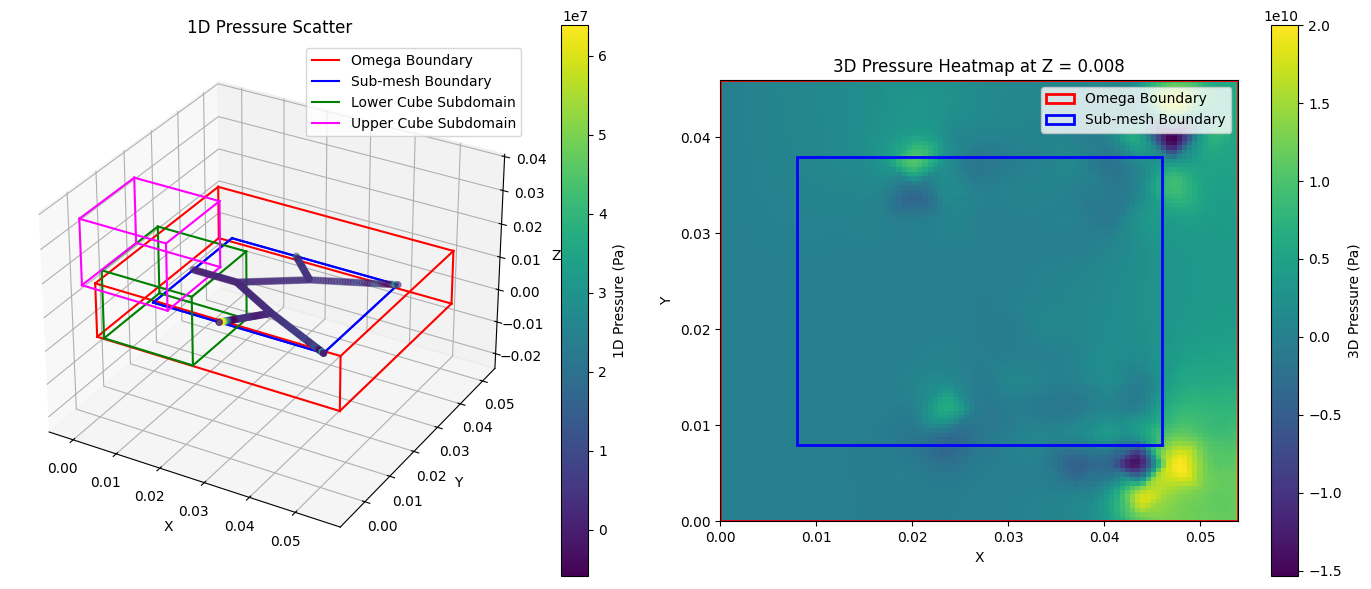

In [204]:
importlib.reload(Visualizer)
cube_lower_bounds = CUBE_TEST.lower_cube_bounds
cube_upper_bounds = CUBE_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

Visualizer.plot_with_boundaries(CUBE_TEST.uh1d, CUBE_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [205]:
CUBE_TEST.compute_lower_cube_flux()

2.248134967982259

In [144]:
import datetime

now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
filename = f"output_{timestamp}.vtk"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBE_TEST.save_vtk(SAVE_PATH)